In [ ]:
#!pip install control
#!pip install slycot
#!pip install plotly
#!pip install nbformat
#!pip install SciencePlots
#!pip install latex


In [113]:
# importa os modulo necessários 

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from scipy.integrate import odeint
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter

import control as ct
from slycot import *
import scienceplots
import latex


# 1 Modelagem pelo módulo Sympy

In [57]:
# Definindo as variáveis simbólicas

# Constantes
M, m1, m2, m3, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 m3 l1 l2 J1 J2 g t  f0 f1 f2')

# Variáveis
phi1, phi2, x,u ,theta1, theta2 = sym.symbols(r'phi1 phi2 x u theta1 theta2', cls=sym.Function) # funções para se trabalhar em cima


In [58]:
# Definindo as derivadas no tempo 

x = x(t)  # Posição x do carro 
u = u(t)  # Variável de controle
u_l = u # Variável de controle (Usada na parte linear)
phi1 = phi1(t) # Ângulo do pêndulo inferior
phi2 = phi2(t) # Ângulo do pêndulo superior
theta1 = theta1(t) # Ângulo do linearizado 
theta2 = theta2(t) # Ângulo do linearizado

x_d = sym.diff(x, t) # Velocidade do carro
phi1_d = sym.diff(phi1, t) # Velocidade angular do pendulo inferior
phi2_d = sym.diff(phi2, t) # Velocidade angular do pendulo superior

x_dd = sym.diff(x_d, t) # Aceleração do carro
phi1_dd = sym.diff(phi1_d, t) # Aceleração angular do pendulo inferior
phi2_dd = sym.diff(phi2_d, t) # Aceleração angular do pendulo superior

# Simplificação
dpdp2=phi2_d*phi2_d
dpdp1=phi1_d*phi1_d
dxdx=x_d*x_d

In [37]:
# Equação de Lagrange: L = T-U

# Energia cinética e potencial carro:
Kc = 1/2 * M *dxdx
Pc = 0

# Energia cinética e potencial do pendulo inferior:
Kp_1 = 1/2 * m1  *dxdx + m1* x_d*l1*phi1_d*sym.cos(phi1)+ 1/2 *dpdp1*(m1*l1*l1+J1)
Pp_1 = m1*g*l1*sym.cos(phi1)

# Energia cinética e potencial do pendulo superior:
Kp_2 = 1/2 *m2*(dxdx + 2*x_d*(2*l1*phi1_d*sym.cos(phi1)+l2*phi2_d*sym.cos(phi2)))\
+1/2 *m2*(4*l1*l1*dpdp1+l2*l2*dpdp2+4*l1*l2*phi1_d*phi2_d*sym.cos(phi1-phi2))+1/2 *J2*dpdp2
Pp_2 = m2*g*(2*l1*sym.cos(phi1)+l2*sym.cos(phi2))

# Energia cinética e potencial total:
P_total = Pc + Pp_1 + Pp_2
K_total = Kc + Kp_1 + Kp_2 
L = K_total - P_total
L

0.5*J2*Derivative(phi2(t), t)**2 + 0.5*M*Derivative(x(t), t)**2 - g*l1*m1*cos(phi1(t)) - g*m2*(2*l1*cos(phi1(t)) + l2*cos(phi2(t))) + l1*m1*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 0.5*m1*Derivative(x(t), t)**2 + 0.5*m2*(2*(2*l1*cos(phi1(t))*Derivative(phi1(t), t) + l2*cos(phi2(t))*Derivative(phi2(t), t))*Derivative(x(t), t) + Derivative(x(t), t)**2) + 0.5*m2*(4*l1**2*Derivative(phi1(t), t)**2 + 4*l1*l2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + l2**2*Derivative(phi2(t), t)**2) + 0.5*(J1 + l1**2*m1)*Derivative(phi1(t), t)**2

In [38]:
# Equaçoes das variaveis generalizadas:

# Coordenada generalizada X:
eqnx = sym.diff(sym.diff(L,x_d),t)-sym.diff(L,x)-u+f0*x_d

# Coordenada generalizada phi1:
eqn_phi1 = sym.diff(sym.diff(L,phi1_d),t)-sym.diff(L,phi1)+(f1+f2)*phi1_d -f2*phi2_d

# Coordenada generalizada phi2:
eqn_phi2 = sym.diff(sym.diff(L,phi2_d),t)-sym.diff(L,phi2)-f2*phi1_d + f2*phi2_d


# Solução das equaçoes das variáveis generalizadas
# Solução para X
sol_xdd = sym.solve(eqnx, x_dd)[0]
#sol_xdd = sym.solve([eqnx], (x_dd), simplify=False, rational=False)#[0]

# Solução para phi1
sol_phi1dd = sym.solve(eqn_phi1, phi1_dd)[0]
#sol_phi1dd = sym.solve([eqn_phi1], (phi1_dd), simplify=False, rational=False)#[0]

# Solução para phi1
sol_phi2dd = sym.solve(eqn_phi2, phi2_dd)[0]
#sol_phi2dd = sym.solve([eqn_phi2], (phi2_dd), simplify=False, rational=False)#[0]

In [6]:
# Soluciona o sistema de equações das variaveis generalizadas
sols = sym.solve([eqnx, eqn_phi1,eqn_phi2], (x_dd,phi1_dd,phi2_dd),
                simplify=False, rational=False)

### Dinâmica Não Linear

Definindo as equações

$$
\begin{align}
\frac{\mathrm{d} ^2 x}{\mathrm{d} t^2} = \frac{\mathrm{d} \omega  }{\mathrm{d} t} \\
\frac{\mathrm{d} x }{\mathrm{d} t} = \omega
\end{align}
$$
Para $X$

$$
\begin{align}
\frac{\mathrm{d} ^2 \phi}{\mathrm{d} t^2} = \frac{\mathrm{d} \zeta }{\mathrm{d} t} \\
\frac{\mathrm{d} \phi }{\mathrm{d} t} = \zeta
\end{align}
$$
Para cada $\phi\in (\phi_1, \phi_2)$

In [39]:
do1dt_f = sym.lambdify((t, M, m1, m2, g , J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[x_dd])
dxdt_f = sym.lambdify(x_d, x_d)

dz1dt_f = sym.lambdify((t, M, m1, m2, g , J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[phi1_dd])
dphi1dt_f = sym.lambdify(phi1_d, phi1_d)

dz2dt_f = sym.lambdify((t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, x_d, phi1_d, phi2_d), sols[phi2_dd])
dphi2dt_f = sym.lambdify(phi2_d, phi2_d)

Define o sistema de ODE para o python $S = (X,\omega,\phi_1,\zeta_1,\phi_2,\zeta_2)$

In [40]:
def dSdt(S, t):
    x, o1, phi1, z1, phi2, z2 = S
    return [
        dxdt_f(o1),
        do1dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
        
        dphi1dt_f(z1),
        dz1dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
        
        dphi2dt_f(z2),
        dz2dt_f(t, M, m1, m2, g, J1, J2, l1, l2, f0, f1, f2, u, x, phi1, phi2, o1, z1, z2),
    ]

In [41]:
# t = np.linspace(0, 20, 2000)
t = np.arange(0,20,0.01)
M=1
m1=1
m2=1
u=0
J1=0.00083
J2=0.00083
l1=0.05
l2=0.05
g=9.81
f0=0.01
f1=0.007
f2=0.007
soluODE = odeint(dSdt, y0=[0, 0.0, 0.08, 0, 0,0], t=t)

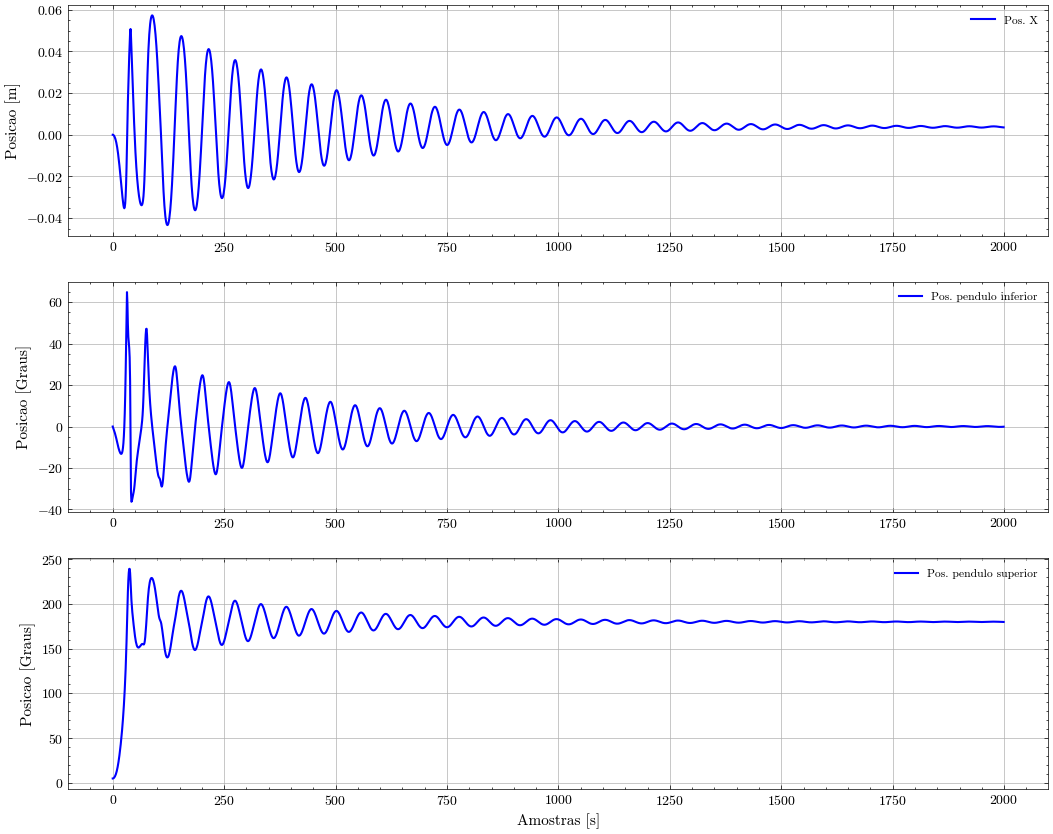

In [131]:
plt.style.use(['science','no-latex'])
plt.figure(figsize=(10,8))
# plt.title('Resposta em malha aberta')
plt.subplot(3,1,1)
plt.plot(soluODE.T[0],'b',linewidth=1.5,label='Pos. X')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Posicao [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(soluODE.T[1]*180/np.pi,'b',linewidth=1.5,label='Pos. pendulo inferior')
# plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Posicao [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(soluODE.T[2]*180/np.pi,'b',linewidth=1.5,label='Pos. pendulo superior')
plt.xlabel('Amostras [s]',fontsize=11)
plt.ylabel('Posicao [Graus]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')
plt.show()

$$
\begin{align}
q_p = \begin{bmatrix}
x\\ \phi_1
\\ \phi_2
\end{bmatrix},\;\;\;\;\;\dot{q}_p = \begin{bmatrix}
\dot{x}\\ \dot{\phi}_1
\\ \dot{\phi}_2
\end{bmatrix},\;\;\;\;\; u_p = \begin{bmatrix}
u\\ 0
\\ 0
\end{bmatrix}
\end{align}
$$

In [43]:
# Matriz dos estados
q = sym.Matrix([x,theta1,theta2])

# Matriz das derivadas de estados
q_d = sym.Matrix([(x_d,phi1_d,phi2_d)])

# Matriz das 2º derivadas de estados
q_dd = sym.Matrix([(x_dd,phi1_dd,phi2_dd)])

# Matriz estados total
q_ef = sym.Matrix([q,q_dd.transpose()])


# Ponto de equilibrio - Linearização
ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0,sym.cos(phi1):1,\
            sym.cos(phi2):1,sym.cos(phi1-phi2):1,sym.sin(phi1):theta1,sym.sin(phi2):theta2}


$$
\begin{align}
H(q_p)\ddot{q_p} + N(q_p,\dot{q_p}) + W(q_p) = V(q_p)u_p
\end{align}
$$


Dinâmica Linear

In [44]:
# Matriz H de Massas do sistema:
H = sym.Matrix((sym.diff(eqnx,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd))).subs(ponto_eq)

# Matriz H inversa
H_inv = H.inv()
H

Matrix([
[1.0*M + 1.0*m1 + 1.0*m2,                    l1*m1 + 2.0*l1*m2,             1.0*l2*m2],
[      l1*m1 + 2.0*l1*m2, 1.0*J1 + 1.0*l1**2*m1 + 4.0*l1**2*m2,          2.0*l1*l2*m2],
[              1.0*l2*m2,                         2.0*l1*l2*m2, 1.0*J2 + 1.0*l2**2*m2]])

In [45]:
# Matriz de efeito corolis e atritos viscosos
N = sym.Matrix((sym.diff(eqnx,q_d),sym.diff(eqn_phi1,q_d),sym.diff(eqn_phi2,q_d))).subs(ponto_eq)
N

Matrix([
[f0,       0,   0],
[ 0, f1 + f2, -f2],
[ 0,     -f2,  f2]])

In [46]:
# Matriz dos efeitos das massas e da gravidade
W = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)]).subs(ponto_eq)
W

Matrix([
[                0],
[-1.4715*theta1(t)],
[-0.4905*theta2(t)]])

In [59]:
# Matriz de entradas

V = sym.Matrix([u_l,0,0])
V

Matrix([
[u(t)],
[   0],
[   0]])

In [60]:
# Multiplicação matricial

C = N*q_d.transpose() + W # C+W

S = (H_inv*C).subs(ponto_eq)
S

Matrix([
[                                  -0.4905*(-1.0*J1*l2*m2 + 1.0*l1**2*l2*m1*m2)*theta2(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2) - 1.4715*(-1.0*J2*l1*m1 - 2.0*J2*l1*m2 - 1.0*l1*l2**2*m1*m2)*theta1(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2)],
[                 -0.4905*(-2.0*M*l1*l2*m2 - 1.0*l1*l2*m1*m2)*theta2(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2) - 1.4715*(1.0*J2*M + 1.0*J2*m1 + 1.0*J2*m2 + 1.0*M*l2**2*m2 + 1.0*l2**2*m1*m2)*theta1(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*

In [61]:
B_0 = sym.Matrix([q_dd.transpose(),H_inv*V])
B_0

Matrix([
[                                                                                                                                                                                                                                                  Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                                                               Derivative(phi1(t), (t, 2))],
[                                                                                                                                                                                                                                               Derivative(phi2(t), (t, 2))],
[(1.0*J1*J2 + 1.0*J1*l2**2*m2 + 1.0*J2*l1**2*m1 + 4.0*J2*l1**2*m2 + 1.0*l1**2*l2**2*m1*m2)*u(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 +

In [71]:
# Criando a Matriz de estados A
A_p = sym.Matrix([q_dd.transpose(),S])
A_j = A_p.jacobian(q_ef)
A_j

Matrix([
[0,                                                                                                                                                                                                                                                         0,                                                                                                                                                                                                                                                                          0, 1, 0, 0],
[0,                                                                                                                                                                                                                                                         0,                                                                                                                                                                                                            

In [72]:
# Criando a Matriz de estados B
B_p = sym.Matrix([q_dd.transpose(),H_inv*V])
B_j = B_p.jacobian([u])
B_j

Matrix([
[                                                                                                                                                                                                                                                                    0],
[                                                                                                                                                                                                                                                                    0],
[                                                                                                                                                                                                                                                                    0],
[(1.0*J1*J2 + 1.0*J1*l2**2*m2 + 1.0*J2*l1**2*m1 + 4.0*J2*l1**2*m2 + 1.0*l1**2*l2**2*m1*m2)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 +

In [70]:
# Valor dos parâmetros do sistema:
valor_param_dGisele = {M:1,m1:1,m2:1,J1:0.00083,J2:0.00083,\
               l1:0.05,l2:0.05,g:9.81,f0:0.01,f1:0.007,f2:0.007}


In [69]:
# Matriz A - Substituindo os parâmetros
A_s = A_j.subs(valor_param_dGisele)
A = np.matrix(A_s).astype(np.float64)
A

matrix([[   0.        ,    0.        ,    0.        ,    1.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            1.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    1.        ],
        [   0.        ,   14.73466591,   -1.64374696,    0.        ,
            0.        ,    0.        ],
        [   0.        , -442.33526109,  147.64194295,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  442.92582886, -344.30101097,    0.        ,
            0.        ,    0.        ]])

In [73]:
# Matriz B
B_s = B_j.subs(valor_param_dGisele)
B = np.matrix(B_s).astype(np.float64)
B

matrix([[  0.        ],
        [  0.        ],
        [  0.        ],
        [  0.77814879],
        [-10.01336453],
        [  3.35116609]])

In [74]:
# Matriz C
C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0]])

# Matriz D
D = np.zeros((3,1))

In [75]:
# Criando o sistema em State Space
sys = ct.ss(A,B,C,D)


# Discretização
Ts = 0.01
sys_discreto = ct.c2d(sys,Ts, method='zoh')

Ad = sys_discreto.A
Bd = sys_discreto.B
Cd = sys_discreto.C
print('Sistema Discreto:', sys_discreto)

Sistema Discreto: <StateSpace>: sys[0]$sampled
Inputs (1): ['u[0]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 1.00000000e+00  7.33720376e-04 -8.10478923e-05  1.00000000e-02
       2.44974831e-06 -2.71677320e-07]
     [ 0.00000000e+00  9.77991778e-01  7.33381421e-03  0.00000000e+00
       9.92649467e-03  2.45103624e-05]
     [ 0.00000000e+00  2.20014426e-02  9.82861431e-01  0.00000000e+00
       7.35310872e-05  9.94276955e-03]
     [ 0.00000000e+00  1.46142716e-01 -1.59822453e-02  1.00000000e+00
       7.33720376e-04 -8.10478923e-05]
     [ 0.00000000e+00 -4.37998234e+00  1.45712802e+00  0.00000000e+00
       9.77991778e-01  7.33381421e-03]
     [ 0.00000000e+00  4.37138405e+00 -3.41244934e+00  0.00000000e+00
       2.20014426e-02  9.82861431e-01]]

B = [[ 3.88437813e-05]
     [-4.98620711e-04]
     [ 1.65235254e-04]
     [ 7.75604726e-03]
     [-9.93154714e-02]
     [ 3.25835785e-02]]

C = [[1. 0. 0. 0. 0. 0.]
     [0. 1.

# 2 Modelagem pelo módulo Numpy

# 3 Estabilidade

In [76]:
#Exibir Matriz discreta A
sym.Matrix(sys_discreto.A)


Matrix([
[1.0, 0.000733720376049382, -8.10478922770698e-5, 0.01,  2.44974831146228e-6, -2.71677320385038e-7],
[  0,    0.977991778268197,  0.00733381421081525,    0,  0.00992649467136372,  2.45103624070375e-5],
[  0,   0.0220014426324458,    0.982861430904178,    0,  7.35310872211125e-5,  0.00994276955200199],
[  0,    0.146142716106745,  -0.0159822452723519,  1.0, 0.000733720376049382, -8.10478922770698e-5],
[  0,    -4.37998233958085,     1.45712801744595,    0,    0.977991778268197,  0.00733381421081525],
[  0,     4.37138405233785,    -3.41244933599674,    0,   0.0220014426324458,    0.982861430904178]])

In [77]:
#Exibir Matriz discreta B

sym.Matrix(sys_discreto.B)

Matrix([
[  3.88437813038502e-5],
[-0.000498620710872838],
[ 0.000165235254387502],
[  0.00775604725906874],
[   -0.099315471360343],
[   0.0325835785369049]])

In [78]:
#Exibir Matriz discreta C

sym.Matrix(sys_discreto.C)

Matrix([
[1.0,   0,   0, 0, 0, 0],
[  0, 1.0,   0, 0, 0, 0],
[  0,   0, 1.0, 0, 0, 0]])

In [79]:
# MAtriz de controlabilidade
Co = ct.ctrb(Ad,Bd)
rank = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',rank)
Co_s =sym.Matrix(Co)
Co_s

Rank da Matriz de controlabilidade: 6


Matrix([
[  3.88437813038502e-5, 0.000115772863622379, 0.000190466742827359, 0.000261566913824604, 0.000327903743276532, 0.000388555438773389],
[-0.000498620710872838, -0.00147149101297509, -0.00237272557931563, -0.00315939801542793, -0.00379550293804701, -0.00425409579994399],
[ 0.000165235254387502, 0.000468101221582499, 0.000690172168305373,  0.00078417921680752, 0.000712284217549139, 0.000448961073428659],
[  0.00775604725906874,  0.00760502602835415,  0.00731098925527181,  0.00688945190513187,  0.00636247735163702,  0.00575731388628023],
[   -0.099315471360343,  -0.0944660337075228,  -0.0850610952510404,  -0.0716697030327761,  -0.0550995812134601,   -0.036345452776279],
[   0.0325835785369049,   0.0270965394213194,   0.0165239304368125,   0.0016419947904163,   -0.016449897457841,   -0.036402474847977]])

In [80]:
# MAtriz de observabilidade
Ob = ct.obsv(Ad,Cd)
rank_obsr = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',rank_obsr)
Ob_s = sym.Matrix(Ob)
Ob_s

Rank da Matriz de observabilidade: 6


Matrix([
[1.0,                    0,                     0,    0,                    0,                    0],
[  0,                  1.0,                     0,    0,                    0,                    0],
[  0,                    0,                   1.0,    0,                    0,                    0],
[1.0, 0.000733720376049382,  -8.10478922770698e-5, 0.01,  2.44974831146228e-6, -2.71677320385038e-7],
[  0,    0.977991778268197,   0.00733381421081525,    0,  0.00992649467136372,  2.45103624070375e-5],
[  0,   0.0220014426324458,     0.982861430904178,    0,  7.35310872211125e-5,  0.00994276955200199],
[1.0,  0.00289901940164222, -0.000310651541463285, 0.02,  1.94541203499027e-5, -2.11906816729805e-6],
[  0,    0.913258545705653,    0.0287610662615021,    0,   0.0194171388778984,  0.00019377871510358],
[  0,   0.0862831987845064,     0.932355893703291,    0,  0.00058133614531074,   0.0195458079447271],
[1.0,  0.00639048509160518, -0.000649180990017071, 0.03,  6.4857761128368

In [81]:
# Polos do sistema
polos = ct.poles(sys_discreto)
zeros_s = ct.zeros(sys_discreto)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)

Os polos do sistema são:  [1.        +0.j         1.        +0.j         0.96749282+0.2528985j
 0.96749282-0.2528985j  0.99336039+0.11504404j 0.99336039-0.11504404j] Os zeros do sistema são:  [-1.+0.j]


(array([1.        +0.j        , 1.        +0.j        ,
        0.96749282+0.2528985j , 0.96749282-0.2528985j ,
        0.99336039+0.11504404j, 0.99336039-0.11504404j]),
 array([-1.+0.j]))

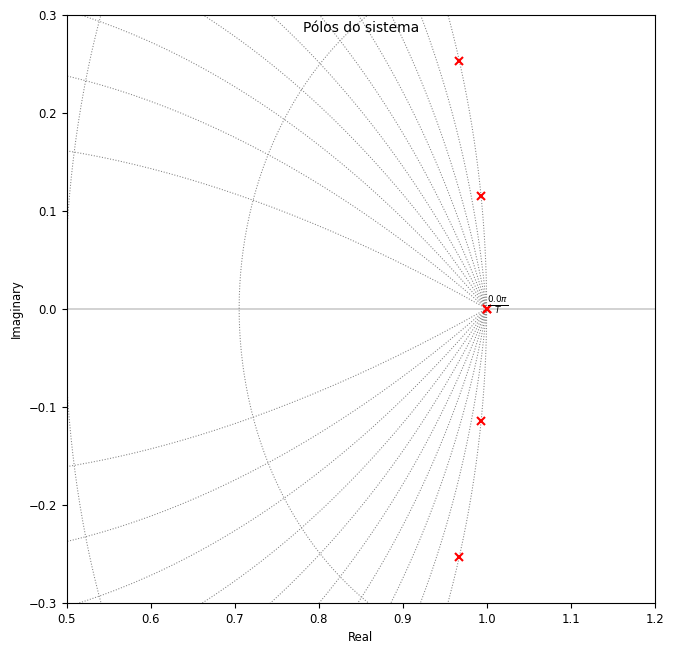

In [82]:
# Pólos do sistema

plt.figure(figsize=(6, 6)) 
ct.pzmap(sys_discreto,plot=True,title ='Pólos do sistema',grid=True,marker_color='r',marker_size=6.4,xlim=[0.5,1.2],ylim=[-0.3,0.3],scaling=True)


In [83]:
# Plotar resposta inicial do sistema

x0 = np.array([[0.0],[0.0],[0.1],[0],[0],[0]])
tp = np.arange(0, 3, Ts) 
#t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial
t,y = ct.initial_response(sys_discreto, tp,x0) # Resposta Inicial
r,d = ct.step_response(sys,tp,x0) # Resposta ao degrau

In [ ]:
plt.style.available

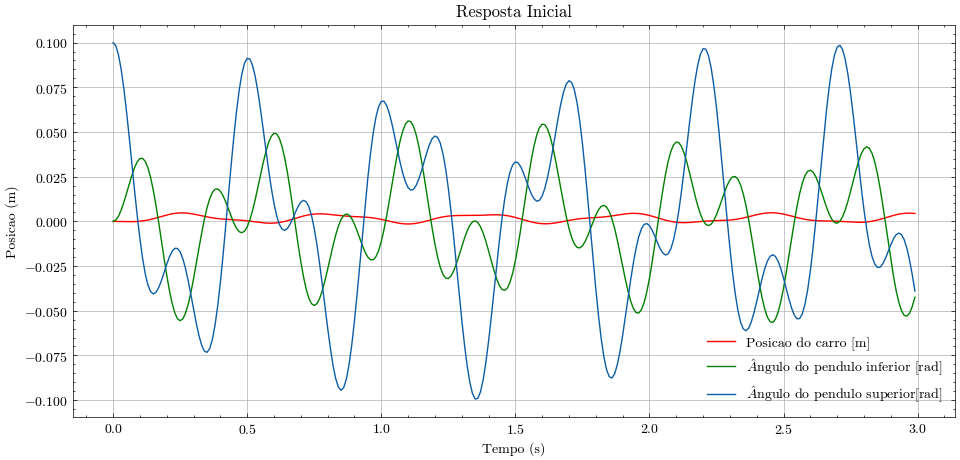

In [127]:
altura = 4
largura = 9

plt.style.use(['science','no-latex'])
#plt.style.use(['science','seaborn-v0_8-whitegrid'])
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0], '-r',label='Posicao do carro [m]')
subplots[1].plot(t,y[1], '-g',label=r'$\hat{A}$ngulo do pendulo inferior [rad]')
subplots[1].plot(t,y[2], label=r'$\hat{A}$ngulo do pendulo superior[rad]')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()



<>:5: SyntaxWarning: invalid escape sequence '\^'
<>:6: SyntaxWarning: invalid escape sequence '\^'
<>:5: SyntaxWarning: invalid escape sequence '\^'
<>:6: SyntaxWarning: invalid escape sequence '\^'
/tmp/ipykernel_9695/2693877603.py:5: SyntaxWarning: invalid escape sequence '\^'
  subplots[1].plot(t,d[1][0], label='\^{a}ngulo phi1')
/tmp/ipykernel_9695/2693877603.py:6: SyntaxWarning: invalid escape sequence '\^'
  subplots[1].plot(t,d[2][0], label='\^{a}ngulo phi2')


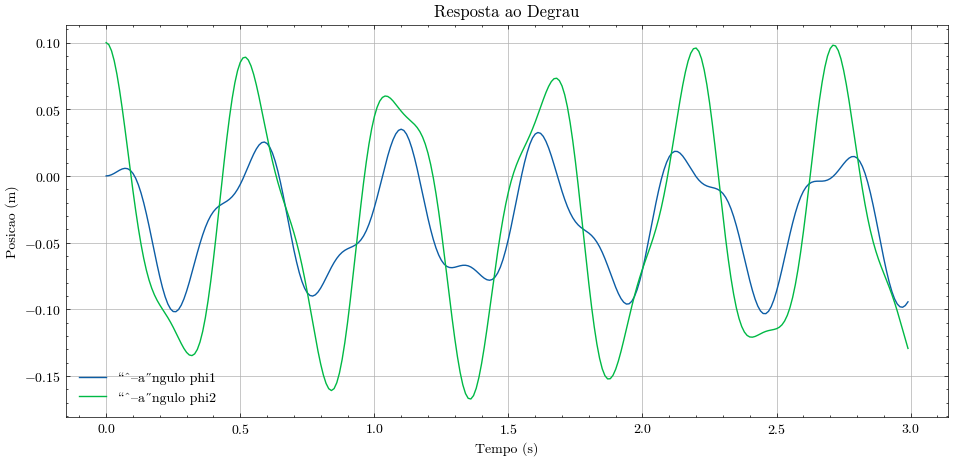

In [110]:
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
#subplots[1].plot(t,d[0][0], label='x')
subplots[1].plot(t,d[1][0], label='\^{a}ngulo phi1')
subplots[1].plot(t,d[2][0], label='\^{a}ngulo phi2')
subplots[1].set_title('Resposta ao Degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posicao (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()